In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from nflows.flows import MaskedAutoregressiveFlow

from counterfactuals.datasets.heloc import HelocDataset
from counterfactuals.datasets.moons import MoonsDataset
from counterfactuals.datasets.law import LawDataset


from counterfactuals.optimizers.approach_three import ApproachThree
from counterfactuals.optimizers.approach_gen_disc_loss import ApproachGenDiscLoss
from counterfactuals.losses import BinaryDiscLoss

from counterfactuals.discriminative_models import LogisticRegression

from counterfactuals.utils import plot_loss_space, plot_model_distribution

/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset = MoonsDataset(file_path="../data/moons.csv")

In [5]:
disc_model = torch.load("../models/disc_model_LR_MoonsDataset.pt")
# disc_model = LogisticRegression(dataset.X_train.shape[1], 1)
# train_dataloader = dataset.train_dataloader(batch_size=64, shuffle=True, noise_lvl=0)
# disc_model.fit(train_loader=train_dataloader, epochs=200)
print(classification_report(dataset.y_test, disc_model.predict(dataset.X_test)))

              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88        52
         1.0       0.85      0.92      0.89        51

    accuracy                           0.88       103
   macro avg       0.89      0.88      0.88       103
weighted avg       0.89      0.88      0.88       103



In [6]:
flow = MaskedAutoregressiveFlow(features=2, hidden_features=4, context_features=1)
cf = ApproachGenDiscLoss(
    gen_model=flow,
    disc_model=disc_model,
    disc_model_criterion=torch.nn.BCELoss(),
    checkpoint_path="model.pt",
    neptune_run=None,
)

In [11]:
train_dataloader = dataset.train_dataloader(batch_size=64, shuffle=True, noise_lvl=1e-5)
test_dataloader = dataset.test_dataloader(batch_size=64, shuffle=False)
cf.train_model(
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    epochs=200,
)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 199, Train: 0.4348, test: 0.3331: 100%|██████████| 200/200 [00:11<00:00, 17.36it/s]


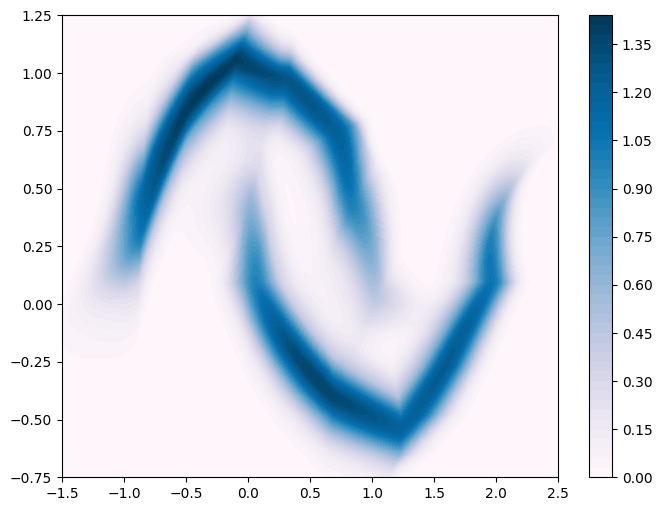

In [12]:
ax = plot_model_distribution(cf.gen_model)

  0%|          | 0/400 [00:00<?, ?it/s]

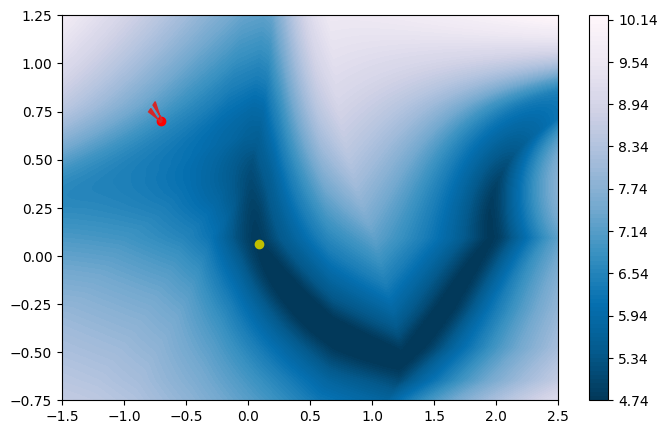

 14%|█▍        | 56/400 [00:00<00:01, 269.47it/s]

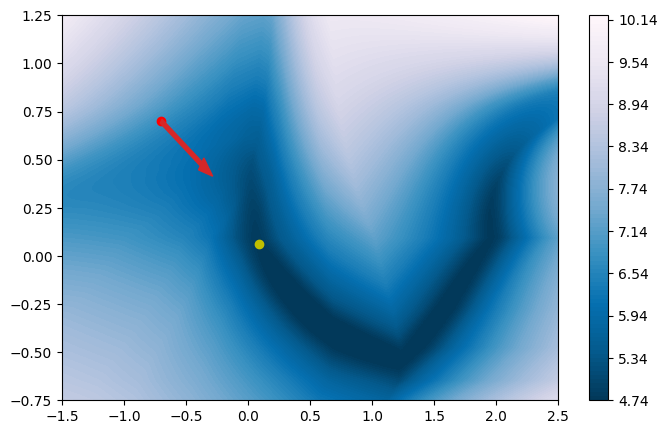

 39%|███▉      | 155/400 [00:00<00:00, 313.08it/s]

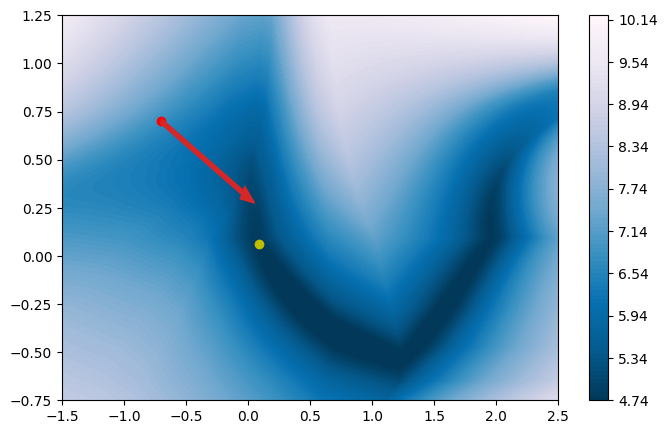

 64%|██████▍   | 255/400 [00:00<00:00, 319.82it/s]

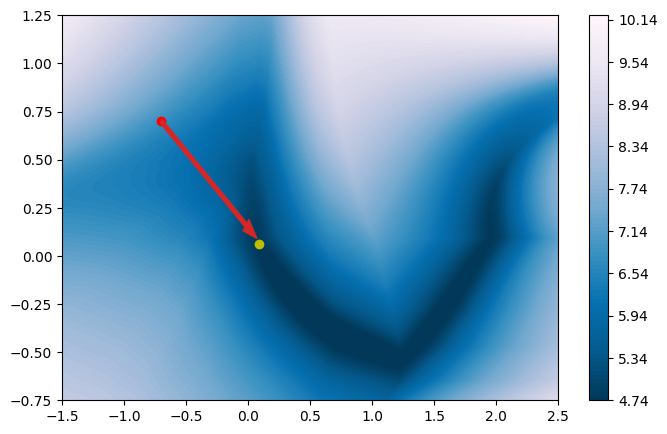

100%|██████████| 400/400 [00:01<00:00, 301.26it/s]


In [22]:
# x_origin = torch.tensor([[0.,  1.0]], requires_grad=False)
# x = torch.tensor([[0.,  1.]], requires_grad=True)

x_origin = torch.tensor([[-0.7,  0.7]], requires_grad=False)
x = torch.tensor([[-0.7,  0.7]], requires_grad=True)

optimizer = torch.optim.Adam([x], lr=0.005)
alpha = 100

num_iterations = 400
context_origin = torch.Tensor([0])
context_target = torch.Tensor([1])
p_hist = []

for i in tqdm(range(num_iterations)):
    losses = cf.search_step(
        x_param=x,
        x_origin=x_origin,
        contexts_origin=context_origin,
        context_target=context_target,
        alpha=alpha,
        delta=0.01
    )
    loss = losses["loss"]
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        p_hist.append(x.detach().numpy().copy())
        plot_loss_space(x, x_origin, cf.search_step, alpha=alpha, delta=0.01)
p_hist.append(x.detach().numpy().copy())
# delta_prob = cf.calculate_median_log_prob(dataset.train_dataloader(batch_size=64, shuffle=False))
# print(delta_prob)
p_hist = np.concatenate(p_hist)


0.8257988


(-1.5, 2.5, -0.75, 1.25)

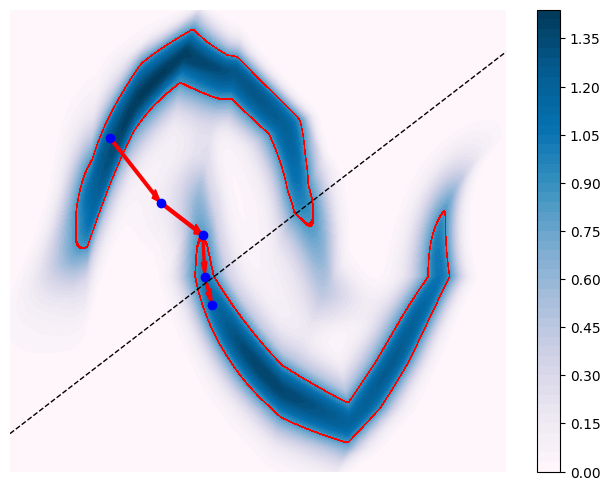

In [23]:
median_prob = cf.calculate_median_log_prob(dataset.train_dataloader(batch_size=64, shuffle=False))
ax = plot_model_distribution(cf.gen_model, median_prob, disc_model)


w1, w2 = list(disc_model.parameters())[0].detach().cpu().numpy()[0]
b = list(disc_model.parameters())[1].detach().cpu().numpy()
c = -b/w2
m = -w1/w2
xmin, xmax = -1.5, 2.5
ymin, ymax = -1.5, 2.5
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.axis("off")


x_res = x.detach().numpy()
# ax.arrow(x_origin[0, 0], x_origin[0, 1], x_res[0,0]-x_origin[0, 0], x_res[0,1]-x_origin[0, 1], width=0.01, length_includes_head=True, color="C3", ls="--")

for i in range(p_hist.shape[0]-1):
    ax.arrow(p_hist[i, 0], p_hist[i, 1], p_hist[i+1, 0]-p_hist[i, 0], p_hist[i+1, 1]-p_hist[i, 1], width=0.015, length_includes_head=True, color="r")
ax.scatter(p_hist[:, 0], p_hist[:, 1], c="b")
print(np.exp(median_prob))
ax.axis("off")
ax.axis("off")

In [130]:
median_prob = cf.calculate_median_log_prob(dataset.train_dataloader(batch_size=64, shuffle=False))

tensor(-0.3879) -0.089833856
